# __InterUni Datathon - Fraud Dectection Analysis__
---
---

**Team 5/12 - Macquarie University**

- Team Member 1: `Chau Anh Cong`
- Team Member 2: `Phan Long Quan Nguyen`
- Team Member 3: ``
- Team Member 4: ``
- Team Member 5: ``
---

## Data Importing & First Look

In [1]:
# Import all the necessary libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Install packages if needed

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install imblearn
# !pip install seaborn
# !pip install plotly
# !pip install scikit-learn
# !pip install missingno
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
# Load data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10966 entries, 0 to 10965
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TransactionNumber    10966 non-null  int64  
 1   UserID               10966 non-null  int64  
 2   Age                  10966 non-null  int64  
 3   Gender               10966 non-null  object 
 4   Occupation           10966 non-null  object 
 5   EducationLevel       10966 non-null  object 
 6   MaritalStatus        10966 non-null  object 
 7   NumDependents        10966 non-null  int64  
 8   Income               10966 non-null  object 
 9   Expenditure          10966 non-null  object 
 10  GiftsTransaction     10966 non-null  object 
 11  TransactionDate      10966 non-null  object 
 12  TransactionTime      10966 non-null  object 
 13  TransactionAmount    10966 non-null  object 
 14  MerchantID           10966 non-null  object 
 15  TransactionType      10966 non-null 

In [4]:
# Find the missing values
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(train_data)

Latitude : 43 (0.392%)
Longitude : 43 (0.392%)


In [5]:
# Drop rows with missing values since they are few
train_data.dropna(inplace=True)

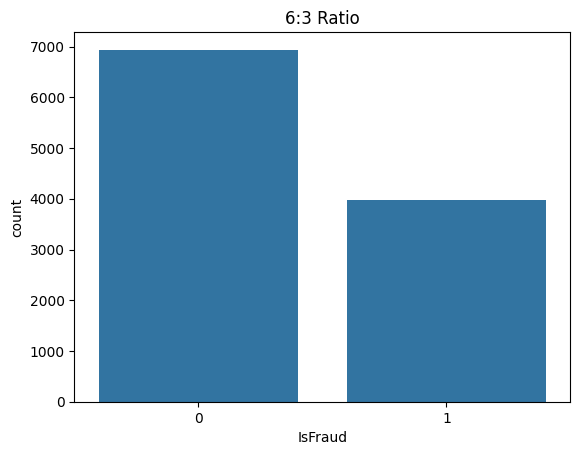

In [6]:
# Plot the distribution of IsFraud
train_data['IsFraud'].value_counts(normalize=True)
sns.countplot(x='IsFraud', data=train_data)
plt.title('6:3 Ratio')
plt.show()

We'll under sample the data for the model training, not for the EDA.

## Data Preprocessing

In [7]:
# Mapping for categorical variables
gender_mapping = {
    'fem': 'Female',
    'Female': 'Female',
    'she': 'Female',
    'woman': 'Female',
    'he': 'Male',
    'man': 'Male',
    'Male': 'Male',
    'isnotfemale': 'Male',
    'isnotmale': 'Female',
}

location_mapping = {
    'Adelaide': 'Adelaide',
    'adl': 'Adelaide',
    'Adelaide City': 'Adelaide',
    'Adl': 'Adelaide',
    'Bne': 'Brisbane',
    'BNE': 'Brisbane',
    'brisbane': 'Brisbane',
    'Brisbane': 'Brisbane',
    'canberra': 'Canberra',
    'Canberra': 'Canberra',
    'CBR': 'Canberra',
    'Cbr': 'Canberra',
    'c': 'Canberra',
    'darwin': 'Darwin',
    'Darwin': 'Darwin',
    'Drw': 'Darwin',
    'DRW': 'Darwin',
    'Hbt': 'Hobart',
    'HBT': 'Hobart',
    'hobart': 'Hobart',
    'Hobart': 'Hobart',
    'Mel': 'Melbourne',
    'melb': 'Melbourne',
    'Melb': 'Melbourne',
    'melbourne': 'Melbourne',
    'Melbourne': 'Melbourne',
    'Melburne': 'Melbourne',
    'Melburn': 'Melbourne',
    'MLB': 'Melbourne',
    'perth': 'Perth',
    'Perth': 'Perth',
    'PTH': 'Perth',
    'Pth': 'Perth',
    'Syd': 'Sydney',
    'Sydney': 'Sydney',
    'SYD': 'Sydney',
    'sydney': 'Sydney'
}


mobile_mapping = {
    'android': 'Mobile',
    'galaxys7': 'Mobile',
    'iphone 15': 'Mobile',
    'mob': 'Mobile',
    'smartphone': 'Mobile',
    'Mobile': 'Mobile',
}

In [8]:
# Age correction
def age_correction(age):
    if age < 0:
        age = abs(age)
    if age % 1000 == 0:
        age = age/1000

    return age

# Convert time to standard pandas time
def standard_time(time_str):
    try:
        if 'AM' in time_str or 'PM' in time_str:
            return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
        
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    
    except (ValueError, TypeError):
        try:
            parts = time_str.split('/')
            corrected_time = f'{parts[0]}:{parts[1]}:{parts[2]}'
            return pd.to_datetime(corrected_time, format='%H:%M:%S').strftime('%H:%M:%S')
        except Exception:
            return None

# Create a feature for the time of the day
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'
    
# Convert the currency to AUD
def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown"


In [9]:
# Clean other columns and apply the mappings
def Cleaning(df):
    df['Age'] = df['Age'].apply(age_correction)

    df.dropna(subset=['TransactionTime'], inplace=True)
    df['TransactionTime'] = df['TransactionTime'].apply(standard_time)
    df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H:%M:%S').dt.hour
    df['TransactionTime'] = df['TransactionTime'].apply(categorize_time)

    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%Y-%m-%d')
    df['Date'] = df['TransactionDate'].dt.day   
    df['Month'] = df['TransactionDate'].dt.month  
    df['Weekday'] = df['TransactionDate'].dt.day_name()

    df['Income'], df['Income_Currency'] = zip(*df['Income'].apply(get_currency_and_symbol))
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')  

    df['Expenditure'], df['Expenditure_Currency'] = zip(*df['Expenditure'].apply(get_currency_and_symbol))
    df['Expenditure'] = pd.to_numeric(df['Expenditure'], errors='coerce')

    df['GiftsTransaction'], df['GiftsTransaction_Currency'] = zip(*df['GiftsTransaction'].apply(get_currency_and_symbol))
    df['GiftsTransaction'] = pd.to_numeric(df['GiftsTransaction'], errors='coerce')

    df['TransactionAmount'], df['TransactionAmount_Currency'] = zip(*df['TransactionAmount'].apply(get_currency_and_symbol))
    df['TransactionAmount'] = pd.to_numeric(df['TransactionAmount'], errors='coerce') 

    df['EmailDomain'] = df['EmailDomain'].apply(lambda x: x.split('@')[1])
    df['Gender'] = df['Gender'].map(gender_mapping).fillna('Other')
    df['TransactionLocation'] = df['TransactionLocation'].replace(location_mapping)
    df['DeviceType'] = df['DeviceType'].replace(mobile_mapping)
    
    return df

## Encoding

In [10]:
# Binary encoding for the columns
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

# Ordinal encoding for the columns
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

# Columns to one hot encode
nominal_columns = ["Weekday", "MaritalStatus", "TransactionType", "TransactionLocation", "Income_Currency", "Expenditure_Currency", 
                    "GiftsTransaction_Currency", "TransactionAmount_Currency", "TransactionTime","DeviceType", "MerchantID", "EmailDomain"]
# Columns to ordinal encode
occupation_order = [
    "Student",
    "Unemployed",
   "Retired", 
    "Professional",
]
education_order = [
    "High School","Bachelor","Master","PhD"
]

# Encoding the data
def Encoding(df, drop_id=True):
    df = binary_encode(df, "Gender", "Male")
    df = ordinal_encode(df, "Occupation", occupation_order)
    df = ordinal_encode(df, "EducationLevel", education_order)
    df = binary_encode(df, "Terrorism", True)

    # One hot encoding for the rest
    df = pd.get_dummies(df, columns=nominal_columns, prefix=nominal_columns, dtype=int)

    # Keep only relevant columns after cleaning
    if drop_id:
        columns_to_drop = ["TransactionNumber", "UserID", "TransactionDate"]
    else:
        columns_to_drop = ["UserID", "TransactionDate"]
    
    df = df.drop(columns=columns_to_drop)
    
    return df
    

In [11]:
def PreProcess(df, drop_id=True):
    df_cleaned = Cleaning(df)
    df_encoded = Encoding(df_cleaned, drop_id)
    return df_encoded

train_df_cleaned = PreProcess(train_data)
test_df_cleaned = PreProcess(test_data, drop_id=False)

## Exploratory Data Analysis

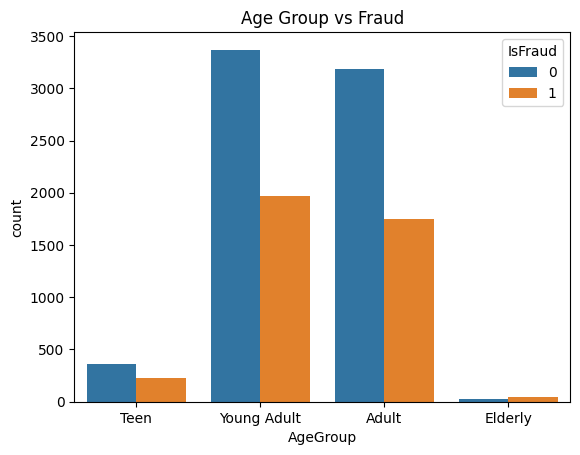

In [12]:
# What age group is more likely to commit fraud?
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 18, 35, 60, 100], labels=['Teen', 'Young Adult', 'Adult', 'Elderly'])

# Plot the AgeGroup column
sns.countplot(x='AgeGroup', data=train_data, hue='IsFraud')
plt.title('Age Group vs Fraud')
plt.show()

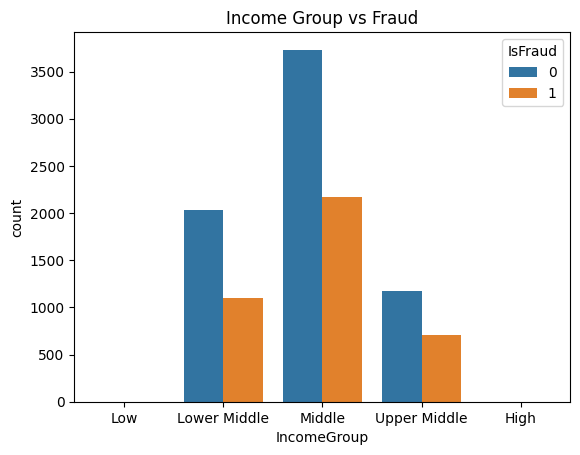

In [13]:
# Are lower-income individuals more likely to commit fraud, or do high-income individuals also play a role?
train_data['IncomeGroup'] = pd.cut(train_data['Income'], bins=[0, 10000, 50000, 100000, 500000, 1000000], labels=['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High'])

# Plot the IncomeGroup column
sns.countplot(x='IncomeGroup', data=train_data, hue='IsFraud')
plt.title('Income Group vs Fraud')
plt.show()

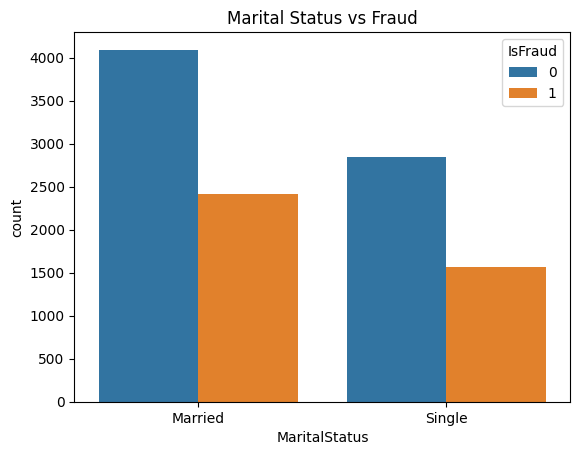

In [14]:
# Determine if couples or single individuals are more prone to committing fraud. Are certain relationship statuses (e.g., married, single) associated with higher fraud risk?
train_data['MaritalStatus'] = train_data['MaritalStatus'].apply(lambda x: 'Single' if x == 'Single' else 'Married')

# Plot the MaritalStatus column
sns.countplot(x='MaritalStatus', data=train_data, hue='IsFraud')
plt.title('Marital Status vs Fraud')
plt.show()

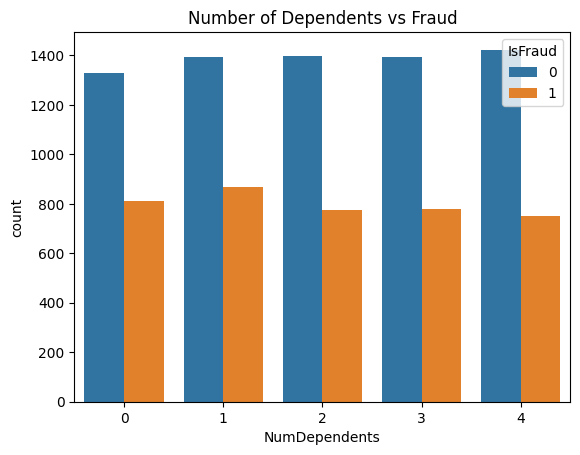

In [15]:
#  Check if having fewer dependents correlates with a higher likelihood of committing fraud.
# Plot the NumDependents column
sns.countplot(x='NumDependents', data=train_data, hue='IsFraud')
plt.title('Number of Dependents vs Fraud')
plt.show()

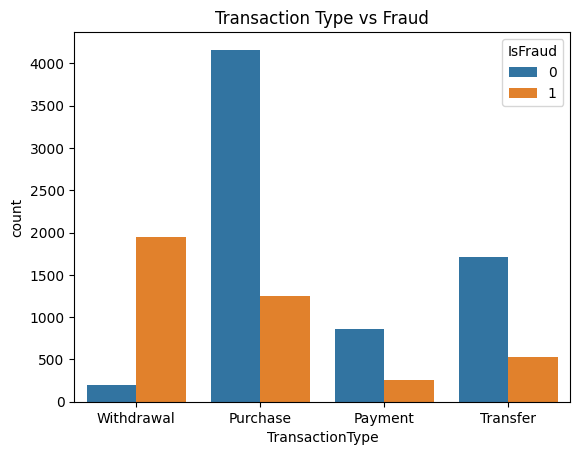

In [16]:
# Identify which types of transactions (withdrawals, purchases, payments, transfers) occur most frequently before a fraudulent event. Are some types (e.g., purchases) more commonly linked to fraud?
# Plot the TransactionType column
sns.countplot(x='TransactionType', data=train_data, hue='IsFraud')
plt.title('Transaction Type vs Fraud')
plt.show()

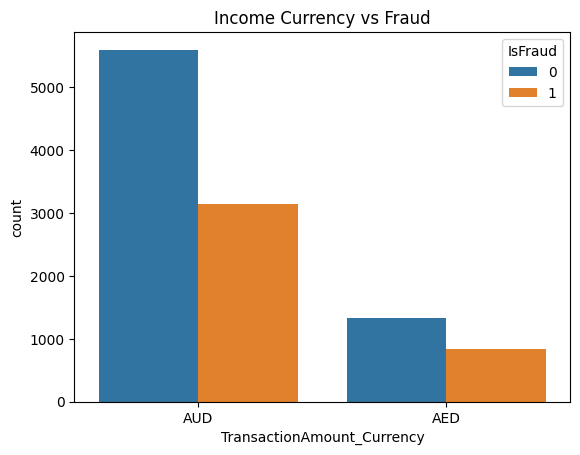

In [17]:
sns.countplot(x='TransactionAmount_Currency', data=train_data, hue='IsFraud')
plt.title('Income Currency vs Fraud')
plt.show()

<Axes: xlabel='UserTenureGroup', ylabel='count'>

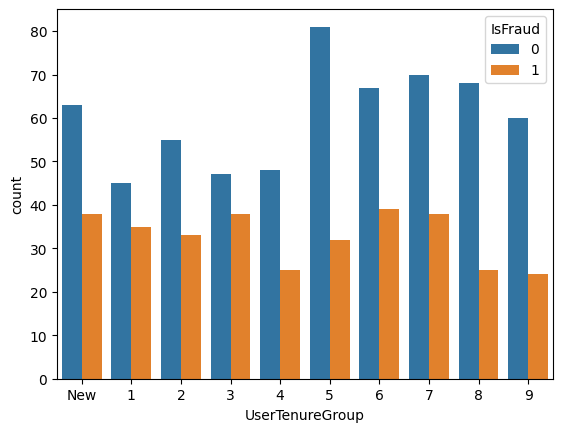

In [18]:
# does new account cause more fraud?
train_data['UserTenureGroup'] = pd.cut(train_data['UserTenure'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=['New', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Plot the UserTenureGroup column
sns.countplot(x='UserTenureGroup', data=train_data, hue='IsFraud')

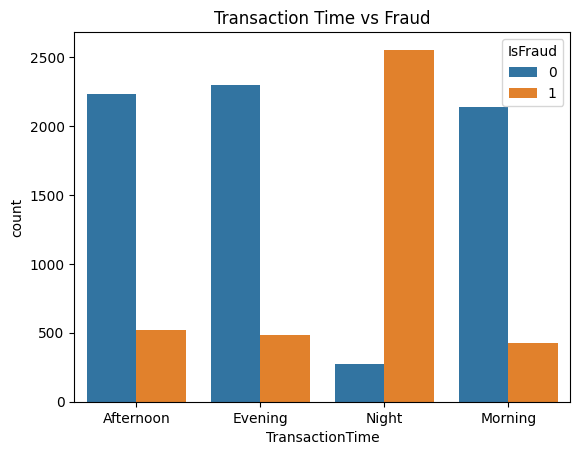

In [19]:
# does late night = more fraud?
sns.countplot(x='TransactionTime', data=train_data, hue='IsFraud')
plt.title('Transaction Time vs Fraud')
plt.show()

In [20]:
# Get the UserID that has most fraud
train_data[train_data['IsFraud'] == 1]['UserID'].value_counts()[:10]

UserID
2479    8
2616    7
4052    7
1077    7
1951    7
495     7
491     7
571     6
1803    6
899     6
Name: count, dtype: int64

In [21]:
fraud_counts = train_data[train_data['IsFraud'] == 1]['UserID'].value_counts()
frequency_of_counts = fraud_counts.value_counts()
print(frequency_of_counts) 

count
1    1419
2     578
3     219
4     111
5      35
6      14
7       6
8       1
Name: count, dtype: int64


In [22]:
# The UserID with most fraud
train_data[train_data['UserID'] == 2479]

,TransactionNumber,UserID,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,...,Date,Month,Weekday,Income_Currency,Expenditure_Currency,GiftsTransaction_Currency,TransactionAmount_Currency,AgeGroup,IncomeGroup,UserTenureGroup
605,8522,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
2135,10246,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
2918,2441,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
6153,3262,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
6453,16707,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,72050.398,...,29,5,Monday,AUD,AED,AUD,AED,Adult,Upper Middle,NaN
6558,12601,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,27,6,Tuesday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
9357,7151,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN
9565,8946,2479,43.0,Male,Professional,Bachelor,Married,4,114935.58,82674.010,...,29,5,Monday,AUD,AUD,GBP,AUD,Adult,Upper Middle,NaN


In [23]:
# List of users with 5 or more frauds
fraudulent_users = fraud_counts[fraud_counts >= 4].index

In [24]:
# Find the characteristics of the fraudulent users
fraudulent_user_data = train_data[train_data['UserID'].isin(fraudulent_users)]
fraudulent_user_data.describe()

,TransactionNumber,UserID,Age,NumDependents,Income,Expenditure,GiftsTransaction,TransactionDate,TransactionAmount,Latitude,Longitude,UserTenure,IsFraud,Date,Month
count,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000
mean,9161.787986,2521.726737,34.151943,1.848057,71886.747326,37886.717972,6334.592822,2023-08-17 10:03:48.975265280,410.199353,-30.983994,141.533785,62.623086,0.886926,16.014134,8.042403
min,32.000000,9.000000,18.000000,0.000000,17997.690000,6909.913500,19.350000,2023-01-03 00:00:00,1.816500,-41.640079,-56.451390,1.000000,0.000000,1.000000,1.000000
25%,4810.000000,1379.000000,25.000000,1.000000,49762.020000,23582.610000,1933.146000,2023-05-31 00:00:00,38.500000,-37.020100,142.702789,31.000000,1.000000,9.000000,5.000000
50%,8780.000000,2616.000000,33.000000,2.000000,66419.100000,34206.020000,4284.810000,2023-09-11 00:00:00,136.990000,-31.840233,144.964600,66.000000,1.000000,16.000000,9.000000
75%,13618.000000,3673.000000,41.000000,3.000000,85488.060000,48035.850000,8678.950000,2023-11-09 00:00:00,447.706000,-25.042261,145.612793,93.000000,1.000000,24.000000,11.000000
max,18211.000000,4948.000000,68.000000,4.000000,156761.270000,103785.430000,39736.980000,2023-12-30 00:00:00,5335.290000,52.734160,149.012375,119.000000,1.000000,31.000000,12.000000
std,5240.950487,1409.581856,10.847322,1.382761,30857.513487,19321.441248,6475.303529,NaN,685.513829,6.686584,11.304909,34.188217,0.316870,8.815311,3.210477


## Predictive Analytics

### Data Re-sampling

explain what we did here

In [25]:
rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_data.drop(columns=['IsFraud']), train_data['IsFraud'])

train_df = pd.concat([X_rus, y_rus], axis=1)
train_df.reset_index(drop=True, inplace=True)

### Modelling

In [26]:
y = train_df_cleaned['IsFraud']
X = train_df_cleaned.drop('IsFraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Random Forest Classifier

In [27]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                scoring="f1", cv=10, refit=True, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
rf_best = random_search.best_estimator_

# Make predictions
rf_y_pred = rf_best.predict(X_test)

rf_f1 = f1_score(y_test, rf_y_pred)
print(f"Random Forest F1 Score: {rf_f1}")

Random Forest F1 Score: 0.9948320413436692


### XGBoost Classifier

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10]
}

# Initialize the XGBoost Regressor
xg_classifier = XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_classifier, param_distributions=param_grid, 
                                    cv=5, scoring="f1", refit=True, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
xgb_best = random_search.best_estimator_

# Make predictions
xgb_y_pred = xgb_best.predict(X_test)

xgb_f1 = f1_score(y_test, xgb_y_pred)
print(f"XGBoost F1 Score: {xgb_f1}")

XGBoost F1 Score: 0.9987146529562982
